# Unterpunkt 3: The time-dependent Schrödinger equation
# in one dimension with Crank-Nicolson

In [28]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Schrödinger lösen

In [29]:

def schroedinger_cn(Nx, dx, Nt, dt, psi0, V):
    # Schritte nach Angabe
    # Schritt 1: Randbedingungen
    psi = np.zeros((Nt+1, Nx), dtype=complex)
    psi[0] = psi0
    
    # Schritt 2: a_k berechnen
    a = np.zeros(Nx, dtype=complex)
    a[1] = 2 * (1 + dx*dx*V[1] - 1j*2*dx*dx/dt)

    for k in range(2, Nx-1):
        a[k] = 2 * (1 + dx*dx*V[k] - 1j*2*dx*dx/dt) - 1/a[k-1]

    # Schritt 3–7: Zeitentwicklung
    for n in range(Nt):
        # Schritt 4: Omega_k^n
        Omega = np.zeros(Nx, dtype=complex)
        for k in range(1, Nx-1):
            Omega[k] = (
                -psi[n, k-1]
                + 2*(1j*2*dx*dx/dt + 1 + dx*dx*V[k]) * psi[n, k]
                - psi[n, k+1]
            )

        # Schritt 5: b_k^n
        b = np.zeros(Nx, dtype=complex)
        b[1] = Omega[1]
        for k in range(2, Nx-1):
            b[k] = b[k-1]/a[k-1] + Omega[k]

        # Schritt 6: Rückwärtssubstitution
        psi[n+1, 0] = 0
        psi[n+1, -1] = 0
        for k in range(Nx-2, 0, -1):
            psi[n+1, k] = (psi[n+1, k+1] - b[k]) / a[k]

    return psi


### Unterpunkt b: Gauss Packet

In [53]:

def gauss_packet(Nx, dx, sigma, x0, q):
    
    x = np.arange(Nx) * dx
    psi0 = np.exp(-((x - x0)**2) / (2*sigma**2)) * np.exp(1j * q * x)
    psi0[0] = 0
    psi0[-1] = 0
    psi0 /= np.sqrt(np.sum(np.abs(psi0)**2) * dx) # Normierung sonst is propability nicht conserved
    return psi0


dx= 0.03
Nx=2000      
dt = 0.01
Nt= 2000     


sigma =10
x0= 25  #komische anfangsbedinugnen, also x0 auf 25 gesetzt
q=2

V = np.zeros(Nx)

psi0 = gauss_packet(Nx, dx, sigma, x0, q)
psi =schroedinger_cn(Nx, dx, Nt, dt, psi0, V)


## Verification von den Sachen
x = np.arange(Nx) * dx
dx = x[1] - x[0]
t= np.arange(psi.shape[0]) * dt
rho = np.abs(psi)**2

#es gilt xmax=x0 +vt - also v anhand von fitting finden.
kmax = rho.argmax(axis=1)
xmax =x[kmax]
v = np.polyfit(t, xmax, 1)[0]  # slope

#Breitenberechnugn
P = rho.sum(axis=1) * dx
x1= (rho * x).sum(axis=1) * dx / P
x2 = (rho * x**2).sum(axis=1) * dx / P
d= np.sqrt(x2 - x1**2)

print(d)
print(v) 
print(psi.shape)


[7.06132925 7.06132792 7.06132515 ... 5.15920715 5.16464264 5.17008198]
2.0296904804341125
(2001, 2000)


### Unterpunkt c: Plot
Side Note: Der Plot is zwar ned a schönes zeitlich verlaufendes Gauß Paket- aber des soll mit dem x0=0 setup genau so sein

WEIL wenn wir unser Gauß Paket in x0=0 legen, wird es an dieser Stelle auf 0 gezwungen, sprich

es gibt schon itnerferenzen von Anfang an, also demnach macht es was es soll

sonst kann man x0 und sigma slightly adjusten, dann sieht man einen schönen verlauf ohne interferenzen.

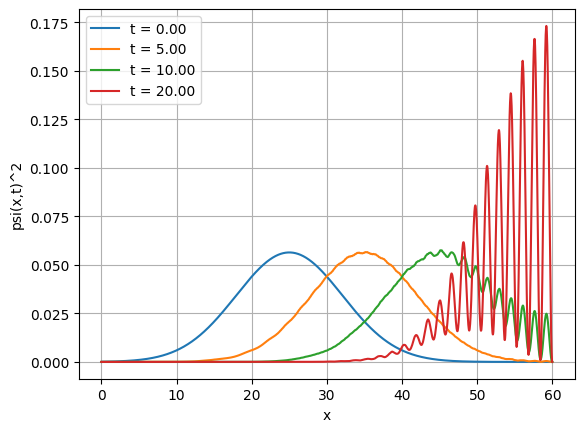

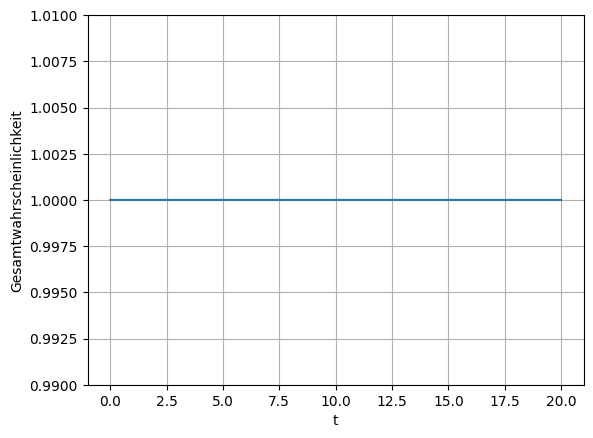

In [54]:

# Raum- und Zeitgitter erstmal
x = np.arange(Nx) * dx
t = np.arange(Nt+1) * dt

# Wahrscheinlichkeitsdichte
rho = np.abs(psi)**2

#Plot 1: psi(x,t)^2 für vier Snapshts
plt.figure()
for n in [0, Nt//4, Nt//2, Nt]: #Snapshots t=0, t=0.5, t=1.0, t=2.0
    plt.plot(x, rho[n], label=f"t = {t[n]:.2f}")
plt.xlabel("x")
plt.ylabel("psi(x,t)^2")
plt.legend()
plt.grid(True)
plt.show()

#Plot 2: Gesamtwhrscheinlichkeit
norm = np.sum(rho, axis=1) * dx

plt.figure()
plt.plot(t, norm)
plt.xlabel("t")
plt.ylabel("Gesamtwahrscheinlichkeit")
plt.ylim(0.99, 1.01)   
plt.grid(True)
plt.show()





### Unterpunkt d: Potentiale

In [32]:

sigma = 20.0
q = 2.0
x0 = 0.0

dx = 0.1
Nx = 5000     
dt = 0.01
Nt = 12000     

x = np.arange(Nx) * dx


V0_list = [1.5, 2.0, 2.5]
a = 100.0
b = 200.0
dbar = 10.0

psi0 = gauss_packet(Nx, dx, sigma, x0, q)


def make_V1(V0):
    return V0 * (
        np.heaviside(x - a, 0.0)- np.heaviside(x - (a + dbar), 0.0)
    )


def make_V2(V0):
    return make_V1(V0) + V0 * (
        np.heaviside(x - b, 0.0)- np.heaviside(x - (b + dbar), 0.0)
    )


psi_V1 = {}   
psi_V2 = {}

for V0 in V0_list:
    V1 = make_V1(V0)
    V2 = make_V2(V0)

    psi_V1[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V1)
    psi_V2[V0] = schroedinger_cn(Nx, dx, Nt, dt, psi0, V2)


### Unteerpunkt e: Plots zu Potentialen

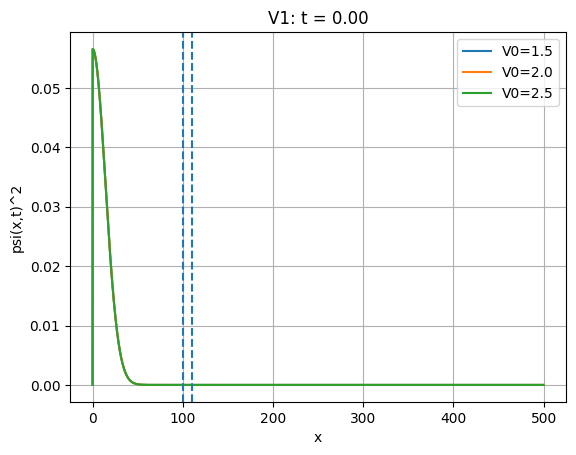

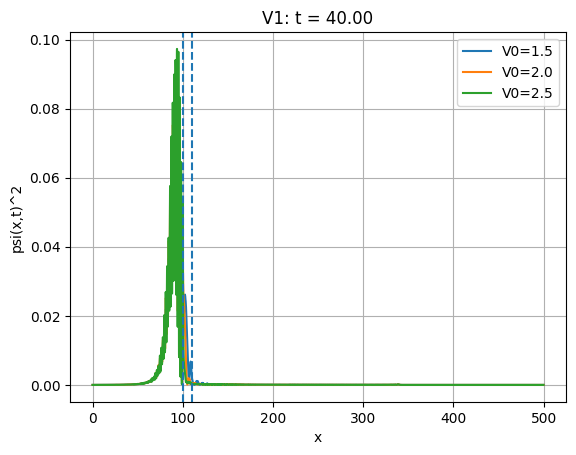

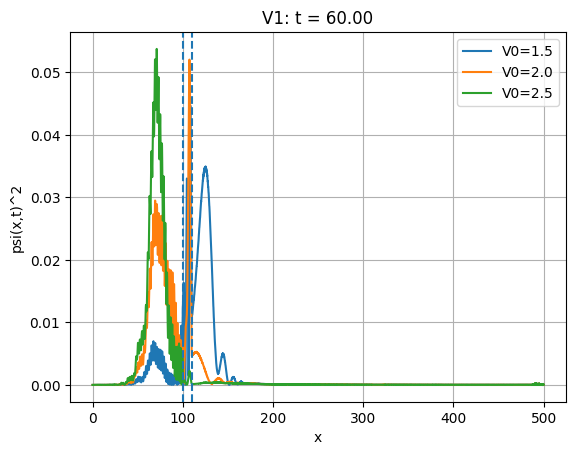

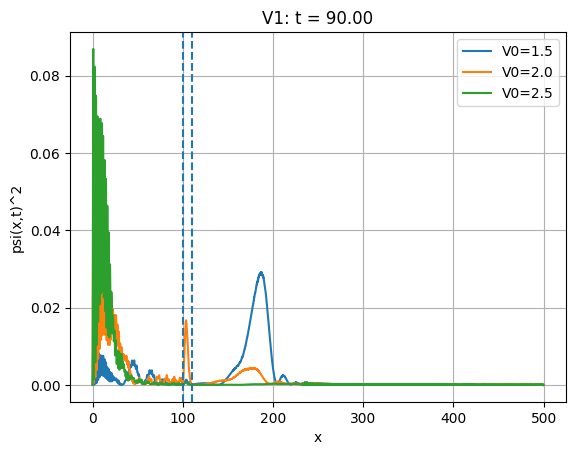

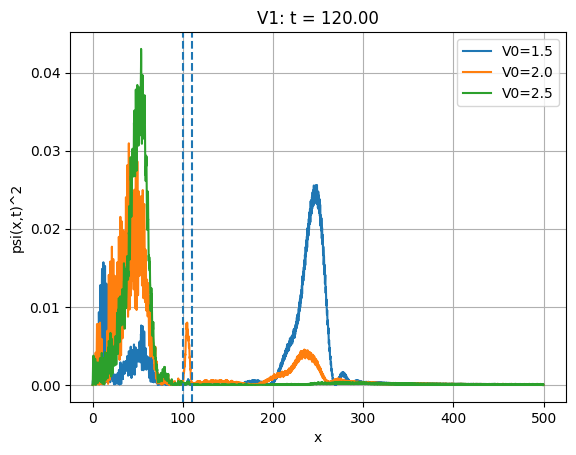

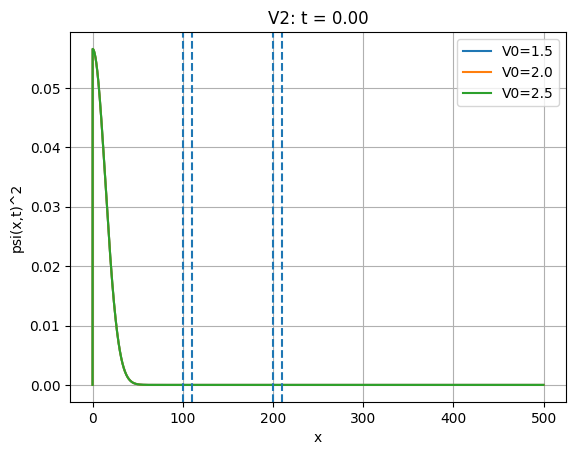

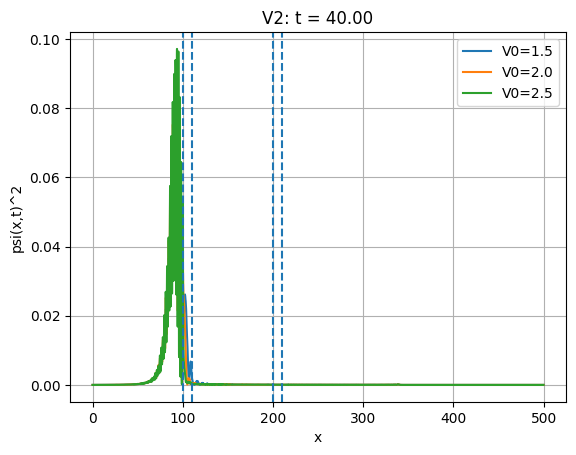

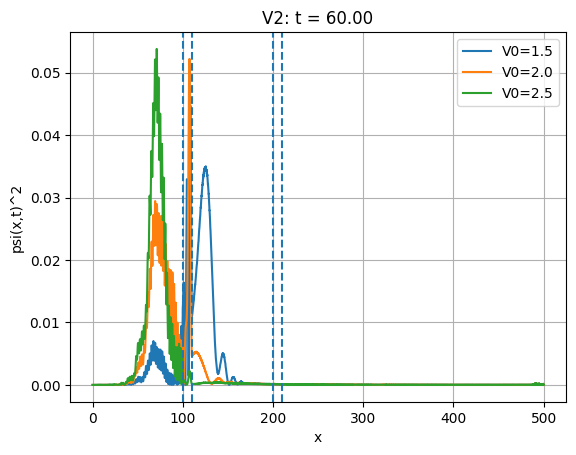

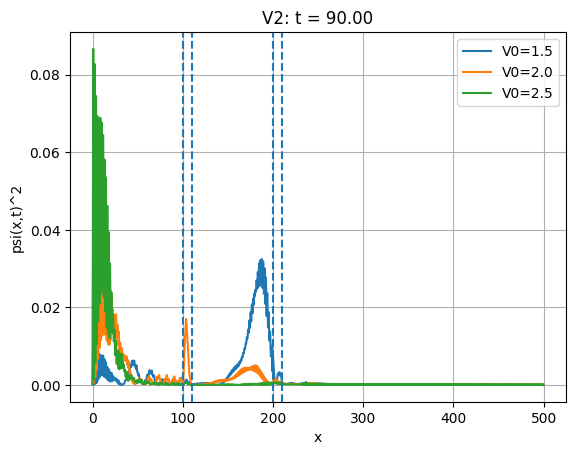

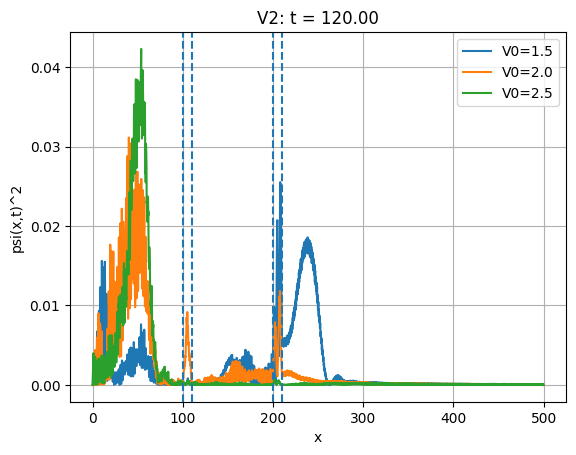

In [33]:

#Zeiten für snapshots 
times = [0, 40, 60, 90, 120]
idx_list = [int(tt / dt) for tt in times]

def plot_snapshots(psi, title, idx_list):
    for idx in idx_list:
        plt.figure()
        for V0 in V0_list:
            plt.plot(x, np.abs(psi[V0][idx])**2, label=f"V0={V0}")
        plt.axvline(a, linestyle="--") 
        plt.axvline(a + dbar, linestyle="--")
        if title == "V2":
            plt.axvline(b, linestyle="--") 
            plt.axvline(b + dbar, linestyle="--")
        plt.xlabel("x")
        plt.ylabel("psi(x,t)^2")
        plt.title(f"{title}: t = {idx*dt:.2f}")
        plt.grid(True) 
        plt.legend() 
        plt.show()

#Plots
plot_snapshots(psi_V1, "V1", idx_list)
plot_snapshots(psi_V2, "V2", idx_list)
